In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from utils import calc_performance, plot_confusion_matrix, calc_test_train_performance
import os
import sklearn.preprocessing as prep 

In [2]:
path = os.getcwd()

In [3]:
# raw_df = pd.read_csv('../data/processed/completeddata.csv',index_col=0)
raw_df = pd.read_csv('/Users/lexili24/1001/DS-GA-1001-Project-master/data/processed/completeddata.csv',index_col=0)

In [4]:
# scale the data to mean 0 sd 1
raw_df.iloc[:,2:-1] = prep.scale(raw_df.iloc[:,2:-1], axis = 0, with_mean = True, with_std = True)

In [5]:
# seperate the data to training & testing sets
train = raw_df[raw_df.Year <= 2016]
test = raw_df[raw_df.Year > 2016]

In [6]:
FEAT_SET = ['ValueOfProduction', 'MaximumColonies', 
            'LostColonies', 'AddedColonies', 'Pesticides', 'OtherDiseases', 
            'UnknownDiseases', 'Tavg', 'Prcp', 'Awnd']
TARGET = 'YieldClass'

In [7]:
X_train = train[FEAT_SET]
y_train = train[TARGET]

X_test = test[FEAT_SET]
y_test = test[TARGET]

## (1) Find the best kernel

In [8]:
# at constant c and gamma, rbf is the best kernel.

param_grid = {'kernel': ('linear','poly','rbf','sigmoid'),
              'degree': np.arange(1,3),
              'decision_function_shape': ('ovo','ovr')
             }
estimater = svm.SVC(probability = True)

grid = GridSearchCV(estimater, param_grid = param_grid, 
                    scoring='accuracy', cv=5, verbose=1, refit=True)

grid.fit(X_train,y_train)

model = grid.best_estimator_

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.3s finished


### Best Params

In [9]:
print(grid.best_params_)

{'decision_function_shape': 'ovo', 'degree': 1, 'kernel': 'rbf'}


### Best Score

In [10]:
grid.best_score_

0.4878048780487805

## 2.1 Parameter Tuning 

In [11]:
#(2) rbf depends on only c and gamma

# grid search
param_grid = {'C':np.logspace(-5,5,10),
              'gamma': np.logspace(-10,10)}
estimater = svm.SVC(probability = True, kernel = 'rbf', decision_function_shape = 'ovo' )

grid = GridSearchCV(estimater, param_grid = param_grid, 
                    scoring='accuracy', cv=5, verbose=1, refit=True)

# fit to SVM 
grid.fit(X_train,y_train)

# find the best model
model = grid.best_estimator_

# compare the result
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)



Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:    9.7s finished


### Best Params

In [12]:
grid.best_params_

{'C': 3.593813663804626, 'gamma': 0.6250551925273976}

### Best Score

In [13]:
grid.best_score_

0.6219512195121951

### Model Performance:
#### The best model appears to be overfitting because the gap between trianing and testing accuracy score. 
- Need to continue tunning with regularization constraint C, while setting gamma. 

In [14]:
calc_test_train_performance(model, X_train, X_test, y_train, y_test)

,Train_Score,Test_Score
cross_entropy,0.610236,1.199657
accuracy,1.000000,0.512195


## 2.2 Continue Tuning C

In [16]:
gamma_best = grid.best_params_['gamma']

In [22]:
param_grid = {'C':np.logspace(0.1,0.2)}
estimater = svm.SVC(probability = True, kernel = 'rbf',decision_function_shape = 'ovo' 
                    , gamma = gamma_best )

grid = GridSearchCV(estimater, 
                    param_grid = param_grid, scoring='accuracy', 
                    cv=5, verbose=1, refit=True)

grid.fit(X_train,y_train)

model = grid.best_estimator_

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.0s finished


### Best Params 

In [23]:
grid.best_params_

{'C': 1.2589254117941673}

### Best Score

In [19]:
grid.best_score_

0.6219512195121951

### Model Performance 

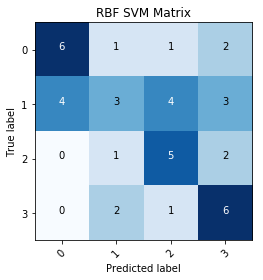

In [20]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=[0,1,2,3], title='RBF SVM Matrix')

In [21]:
calc_test_train_performance(model, X_train, X_test, y_train, y_test)

,Train_Score,Test_Score
cross_entropy,0.627406,1.216559
accuracy,0.939024,0.487805
